In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests

In [5]:
# URLs of the files
train_datas_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module4/exercise/module4_exercise_train.zip'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module4/exercise/Neighborhood_Market_data.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_datas_url, 'module4_exercise_train.zip')
download_file(test_data_url, 'Neighborhood_Market_data.csv')

Downloaded module4_exercise_train.zip from https://www.raphaelcousin.com/modules/data-science-practice/module4/exercise/module4_exercise_train.zip
Downloaded Neighborhood_Market_data.csv from https://www.raphaelcousin.com/modules/data-science-practice/module4/exercise/Neighborhood_Market_data.csv


## 1) Load and combine data from multiple sources (files, API, web scraping).

 #### CityMart_data

In [7]:
# read
df_CityMart_data =  pd.read_csv("CityMart_data.csv", sep=",", index_col='item_code')
df_CityMart_data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified
item_code,,,,,,,,,,
P0019,CityMart,2.81,26.83,38.75,24.89,323,25877.199625,253,202,2023-01-19
P0024,CityMart,3.30,59.23,34.99,21.78,321,45138.128706,21,225,2023-01-24
P0025,CityMart,2.34,22.60,16.90,60.12,291,22962.232800,316,278,2023-01-25
P0034,CityMart,6.54,18.59,68.72,21.99,126,28092.330552,612,233,2023-02-03
P0039,CityMart,9.94,57.89,88.33,35.45,312,181270.870165,968,203,2023-02-08
...,...,...,...,...,...,...,...,...,...,...
P1984,CityMart,8.24,99.78,68.06,11.87,117,80609.488116,333,263,2028-06-06
P1989,CityMart,5.79,71.19,92.39,63.98,250,420812.077518,417,238,2028-06-11
P1992,CityMart,8.64,97.57,8.58,83.35,348,69776.502510,489,219,2028-06-14


#### Greenfield_Grocers_data.csv

In [8]:
# read
df_Greenfield_Grocers_data = pd.read_csv("Greenfield_Grocers_data.csv", sep='|', skiprows=2)
df_Greenfield_Grocers_data.columns = df_Greenfield_Grocers_data.iloc[0]
df_Greenfield_Grocers_data = df_Greenfield_Grocers_data[1:] 

# Nettoyer les noms de colonnes (les transformer en chaînes)
df_Greenfield_Grocers_data.columns = df_Greenfield_Grocers_data.columns.astype(str).str.strip()

# Supprimer les colonnes '1.0', 'nan', ou 'Unnamed'
cols_to_drop = [col for col in df_Greenfield_Grocers_data.columns if col in ['1.0', 'nan'] or col.startswith('Unnamed')]
df_Greenfield_Grocers_data.drop(columns=cols_to_drop, inplace=True)

df_Greenfield_Grocers_data.set_index('ITEM_CODE', inplace=True)

# Renommer l’index
df_Greenfield_Grocers_data.index.name = 'item_code'

# Ecrire les noms de colonne en minuscule
df_Greenfield_Grocers_data.columns = [col.lower() for col in df_Greenfield_Grocers_data.columns]

df_Greenfield_Grocers_data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified
item_code,,,,,,,,,,
P0006,Greenfield_Grocers,5.02,86.68,71.64,16.42,66,101964.18038400002,450,130,2023-01-06
P0014,Greenfield_Grocers,9.91,21.67,54.91,84.8,99,100903.49455999999,827,118,2023-01-14
P0016,Greenfield_Grocers,1.13,60.03,97.39,90.0,348,526168.953,981,136,2023-01-16
P0021,Greenfield_Grocers,0.95,40.36,67.91,99.76,301,273426.95657599997,289,155,2023-01-21
P0028,Greenfield_Grocers,5.24,22.37,61.78,68.67,15,94903.217262,423,177,2023-01-28
...,...,...,...,...,...,...,...,...,...,...
P1983,Greenfield_Grocers,3.13,37.39,74.87,84.11,168,235456.63402300002,31,154,2028-06-05
P1985,Greenfield_Grocers,0.66,30.04,15.77,70.62,5,33454.869096,76,73,2028-06-07
P1988,Greenfield_Grocers,7.28,7.34,89.94,37.33,92,24643.757867999997,770,162,2028-06-10


#### Neighborhood_Market_data

In [9]:
# read
df_Neighborhood_Market_data =  pd.read_csv("Neighborhood_Market_data.csv", sep=",", index_col = 'item_code')
df_Neighborhood_Market_data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,last_modified
item_code,,,,,,,,,
P0002,Neighborhood_Market,5.51,51.79,46.72,72.02,344,174261.666176,287,2023-01-02
P0004,Neighborhood_Market,3.97,84.63,39.42,42.46,189,141651.425916,387,2023-01-04
P0005,Neighborhood_Market,5.99,39.33,83.51,5.12,183,16816.375296,382,2023-01-05
P0010,Neighborhood_Market,4.10,77.43,49.56,74.41,208,285543.225828,656,2023-01-10
P0013,Neighborhood_Market,6.96,95.39,34.61,23.24,114,76725.649196,755,2023-01-13
...,...,...,...,...,...,...,...,...,...
P1972,Neighborhood_Market,5.68,17.89,71.87,95.67,296,123008.113881,411,2028-05-25
P1977,Neighborhood_Market,1.53,84.32,64.91,66.30,171,362873.902560,702,2028-05-30
P1991,Neighborhood_Market,7.79,84.46,82.96,52.14,50,365334.635424,190,2028-06-13


#### HighStreet_Bazaar_data.json

In [10]:

df_HighStreet_Bazaar_data = pd.read_json('HighStreet_Bazaar_data.json', orient='records')
df_HighStreet_Bazaar_data.set_index('item_code', inplace=True)
df_HighStreet_Bazaar_data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified
item_code,,,,,,,,,,
P0001,HighStreet_Bazaar,6.11,75.46,91.62,92.08,78.0,636608.450016,237,346,1672531200000
P0011,HighStreet_Bazaar,4.34,16.97,93.21,54.58,344.0,86333.208546,184,218,1673395200000
P0015,HighStreet_Bazaar,1.37,58.93,11.28,73.87,344.0,49103.634648,946,315,1673740800000
P0017,HighStreet_Bazaar,7.27,51.51,39.21,16.17,138.0,32658.663807,268,228,1673913600000
P0020,HighStreet_Bazaar,0.89,57.50,69.84,6.12,333.0,24576.696000,396,228,1674172800000
...,...,...,...,...,...,...,...,...,...,...
P1978,HighStreet_Bazaar,6.28,72.48,47.71,83.54,322.0,288883.057632,637,235,1843344000000
P1981,HighStreet_Bazaar,0.91,31.13,55.22,71.22,342.0,122427.080292,60,241,1843603200000
P1982,HighStreet_Bazaar,4.65,65.72,82.01,60.75,192.0,327424.104900,925,237,1843689600000


#### SuperSaver_Outlet_data.xlsx

In [11]:
# Lire un fichier excel
df_SuperSaver_Outlet_data_b =  pd.read_excel("SuperSaver_Outlet_data.xlsx", sheet_name=None)
df_SuperSaver_Outlet_data_b

{'Quantity':     item_code  quantity_sold
 0       P0003            198
 1       P0007            211
 2       P0008            200
 3       P0009            209
 4       P0012            186
 ..        ...            ...
 374     P1976            236
 375     P1980            192
 376     P1986            193
 377     P1993            185
 378     P2000            250
 
 [379 rows x 2 columns],
 'Info':     Unnamed: 0          item code  store name   mass  dimension length  \
 0        P0003  SuperSaver_Outlet        2.40  50.90              8.80   
 1        P0007  SuperSaver_Outlet        9.88  43.65             48.64   
 2        P0008  SuperSaver_Outlet        1.45  36.18             10.23   
 3        P0009  SuperSaver_Outlet        6.98  48.13             45.55   
 4        P0012  SuperSaver_Outlet        7.20  23.66             65.90   
 ..         ...                ...         ...    ...               ...   
 374      P1976  SuperSaver_Outlet        5.10  62.99             49

In [12]:
# Lire les deux feuilles du classeur
df_sheet1 = df_SuperSaver_Outlet_data_b["Quantity"]
df_sheet2 = df_SuperSaver_Outlet_data_b["Info"]

In [13]:
df_sheet1.head(10)

,item_code,quantity_sold
0,P0003,198
1,P0007,211
2,P0008,200
3,P0009,209
4,P0012,186
5,P0026,192
6,P0027,148
7,P0031,186
8,P0035,210
9,P0037,176


In [14]:
df_sheet2.head(10)

,Unnamed: 0,item code,store name,mass,dimension length,dimension width,dimension height,days_since last_purchase,package volume,stock age
0,P0003,SuperSaver_Outlet,2.40,50.90,8.80,68.82,337,30825.854400,277,NaN
1,P0007,SuperSaver_Outlet,9.88,43.65,48.64,55.78,16,118428.526080,291,NaN
2,P0008,SuperSaver_Outlet,1.45,36.18,10.23,69.14,315,25590.193596,169,NaN
3,P0009,SuperSaver_Outlet,6.98,48.13,45.55,44.66,295,97909.078190,443,NaN
4,P0012,SuperSaver_Outlet,7.20,23.66,65.90,12.05,40,18788.287700,45,NaN
5,P0026,SuperSaver_Outlet,3.61,31.47,67.27,90.88,73,192391.769472,564,NaN
6,P0027,SuperSaver_Outlet,0.79,25.78,8.78,35.42,262,8017.260328,438,NaN
7,P0031,SuperSaver_Outlet,2.41,93.08,47.66,36.96,280,163961.685888,123,NaN
8,P0035,SuperSaver_Outlet,5.38,40.58,83.02,90.68,311,305496.531088,214,NaN
9,P0037,SuperSaver_Outlet,3.40,39.90,45.02,28.30,128,50835.233400,839,NaN


In [15]:
# suppression des entêtes
df_sheet2.columns = range(df_sheet2.shape[1])

# Attribution des noms
df_sheet2.columns = [
    "item_code",
    "store_name",
    "mass",
    "dimension_length",
    "dimension_width",
    "dimension_height",
    "days_since_last_purchase",
    "package_volume",
    "stock_age",
    "supp"  
]


In [16]:
df_sheet2.head(10)

,item_code,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,supp
0,P0003,SuperSaver_Outlet,2.40,50.90,8.80,68.82,337,30825.854400,277,NaN
1,P0007,SuperSaver_Outlet,9.88,43.65,48.64,55.78,16,118428.526080,291,NaN
2,P0008,SuperSaver_Outlet,1.45,36.18,10.23,69.14,315,25590.193596,169,NaN
3,P0009,SuperSaver_Outlet,6.98,48.13,45.55,44.66,295,97909.078190,443,NaN
4,P0012,SuperSaver_Outlet,7.20,23.66,65.90,12.05,40,18788.287700,45,NaN
5,P0026,SuperSaver_Outlet,3.61,31.47,67.27,90.88,73,192391.769472,564,NaN
6,P0027,SuperSaver_Outlet,0.79,25.78,8.78,35.42,262,8017.260328,438,NaN
7,P0031,SuperSaver_Outlet,2.41,93.08,47.66,36.96,280,163961.685888,123,NaN
8,P0035,SuperSaver_Outlet,5.38,40.58,83.02,90.68,311,305496.531088,214,NaN
9,P0037,SuperSaver_Outlet,3.40,39.90,45.02,28.30,128,50835.233400,839,NaN


In [17]:
df_sheet2.drop(columns=["supp"], errors="ignore", inplace=True)

In [18]:
df_sheet2.head(10)

,item_code,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age
0,P0003,SuperSaver_Outlet,2.40,50.90,8.80,68.82,337,30825.854400,277
1,P0007,SuperSaver_Outlet,9.88,43.65,48.64,55.78,16,118428.526080,291
2,P0008,SuperSaver_Outlet,1.45,36.18,10.23,69.14,315,25590.193596,169
3,P0009,SuperSaver_Outlet,6.98,48.13,45.55,44.66,295,97909.078190,443
4,P0012,SuperSaver_Outlet,7.20,23.66,65.90,12.05,40,18788.287700,45
5,P0026,SuperSaver_Outlet,3.61,31.47,67.27,90.88,73,192391.769472,564
6,P0027,SuperSaver_Outlet,0.79,25.78,8.78,35.42,262,8017.260328,438
7,P0031,SuperSaver_Outlet,2.41,93.08,47.66,36.96,280,163961.685888,123
8,P0035,SuperSaver_Outlet,5.38,40.58,83.02,90.68,311,305496.531088,214
9,P0037,SuperSaver_Outlet,3.40,39.90,45.02,28.30,128,50835.233400,839


In [19]:

df_SuperSaver_Outlet_data = pd.merge(df_sheet2, df_sheet1)


In [20]:
df_SuperSaver_Outlet_data.head(10)

,item_code,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold
0,P0003,SuperSaver_Outlet,2.40,50.90,8.80,68.82,337,30825.854400,277,198
1,P0007,SuperSaver_Outlet,9.88,43.65,48.64,55.78,16,118428.526080,291,211
2,P0008,SuperSaver_Outlet,1.45,36.18,10.23,69.14,315,25590.193596,169,200
3,P0009,SuperSaver_Outlet,6.98,48.13,45.55,44.66,295,97909.078190,443,209
4,P0012,SuperSaver_Outlet,7.20,23.66,65.90,12.05,40,18788.287700,45,186
5,P0026,SuperSaver_Outlet,3.61,31.47,67.27,90.88,73,192391.769472,564,192
6,P0027,SuperSaver_Outlet,0.79,25.78,8.78,35.42,262,8017.260328,438,148
7,P0031,SuperSaver_Outlet,2.41,93.08,47.66,36.96,280,163961.685888,123,186
8,P0035,SuperSaver_Outlet,5.38,40.58,83.02,90.68,311,305496.531088,214,210
9,P0037,SuperSaver_Outlet,3.40,39.90,45.02,28.30,128,50835.233400,839,176


In [21]:
df_SuperSaver_Outlet_data.set_index('item_code', inplace=True)

#### Agregate

In [22]:
data = pd.concat([df_CityMart_data, df_Greenfield_Grocers_data, df_Neighborhood_Market_data, df_HighStreet_Bazaar_data, df_SuperSaver_Outlet_data], axis=0)
data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified
item_code,,,,,,,,,,
P0019,CityMart,2.81,26.83,38.75,24.89,323,25877.199625,253,202,2023-01-19
P0024,CityMart,3.3,59.23,34.99,21.78,321,45138.128706,21,225,2023-01-24
P0025,CityMart,2.34,22.6,16.9,60.12,291,22962.2328,316,278,2023-01-25
P0034,CityMart,6.54,18.59,68.72,21.99,126,28092.330552,612,233,2023-02-03
P0039,CityMart,9.94,57.89,88.33,35.45,312,181270.870165,968,203,2023-02-08
...,...,...,...,...,...,...,...,...,...,...
P1976,SuperSaver_Outlet,5.1,62.99,49.16,65.56,293,203012.335504,464,236,NaN
P1980,SuperSaver_Outlet,4.93,74.91,53.25,52.95,285,211215.299625,163,192,NaN
P1986,SuperSaver_Outlet,4.24,31.52,73.46,55.73,330,129040.541216,755,193,NaN


#### API source

In [23]:
# Récupere les output des endpoints qui sont des dictionnaires
def get_api(endpoint_url):
    try:
        # Make the GET request to the mock API
        response = requests.get(endpoint_url)

        if response.status_code == 200:
            data = response.json()
            print(data["message"])
            return data['data']
        else:
            print(f"Failed to retrieve volume data. Status code: {response.status_code}")
    
    except Exception as e:
        print(f"An error occurred: {e}")
password = get_api("https://www.raphaelcousin.com/api/exercise/auth")["password"]
print(password)
prices = get_api(f"https://www.raphaelcousin.com/api/exercise/{password}/prices")

Authentication successful
RcUZjhdsYLRzwi4
Volume data retrieved successfully


In [24]:
# Convertion d'un dictionnaire en dataframe
# orient='index' : indique que les clés du dictionnaire deviendront les index du DataFrame
#columns=['price'] : nom de la colonne contenant les valeurs du dictionnaire

df_prices = pd.DataFrame.from_dict(prices, orient='index', columns=['unit_cost'])

In [25]:
df_prices.head(10)

,unit_cost
P0001,22.14
P0002,26.91
P0003,16.90
P0004,7.04
P0005,20.84
P0006,15.53
P0007,14.46
P0008,11.72
P0009,14.70
P0010,10.00


#### Aggregate

In [26]:
data = pd.merge(data, df_prices, left_index=True, right_index=True, how='left')
data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified,unit_cost
item_code,,,,,,,,,,,
P0019,CityMart,2.81,26.83,38.75,24.89,323,25877.199625,253,202,2023-01-19,17.86
P0024,CityMart,3.3,59.23,34.99,21.78,321,45138.128706,21,225,2023-01-24,14.04
P0025,CityMart,2.34,22.6,16.9,60.12,291,22962.2328,316,278,2023-01-25,3.38
P0034,CityMart,6.54,18.59,68.72,21.99,126,28092.330552,612,233,2023-02-03,15.11
P0039,CityMart,9.94,57.89,88.33,35.45,312,181270.870165,968,203,2023-02-08,14.20
...,...,...,...,...,...,...,...,...,...,...,...
P1976,SuperSaver_Outlet,5.1,62.99,49.16,65.56,293,203012.335504,464,236,NaN,18.69
P1980,SuperSaver_Outlet,4.93,74.91,53.25,52.95,285,211215.299625,163,192,NaN,17.20
P1986,SuperSaver_Outlet,4.24,31.52,73.46,55.73,330,129040.541216,755,193,NaN,20.91


#### Scrapping sources

In [27]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time

# Permet de lancer un moteur de recherche
# Set up the Selenium WebDriver (e.g., Chrome)
driver = webdriver.Chrome()  # Make sure ChromeDriver is installed
# driver = webdriver.Firefox()
# driver = webdriver.Edge()
# driver = webdriver.Safari()

# Open the URL
url = 'https://www.raphaelcousin.com/module4/scrapable-data'
driver.get(url)

# Wait for the page to fully load (increase time if needed)
time.sleep(5)

# Get the fully rendered page source
html = driver.page_source

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Initialize lists to store scraped data
exercise_data = []

# Charge tous les tableaux numeroté de 0,1,2, etc
# Find both tables
tables = soup.find_all('table')

# Close the Selenium WebDriver
driver.quit()

# On recupere les données des colonnes du tableau 1 qu'on veut stocker en attribuant les mêmes noms que la page web
# Scrape the first table (Course Data)
course_table = tables[1]
for row in course_table.find('tbody').find_all('tr'):
    cols = row.find_all('td')
    exercise_data.append({
        'item_code': cols[0].text,
        'customer_score': int(cols[1].text),
        'total_reviews': int(cols[2].text),
        # 'Updated Timestamp': cols[3].text
    })

# Convert the lists to pandas DataFrames
df_course_exo = pd.DataFrame(exercise_data)
df_course_exo

,item_code,customer_score,total_reviews
0,P0001,2,972
1,P0002,3,260
2,P0003,2,285
3,P0004,5,512
4,P0005,3,85
...,...,...,...
1995,P1996,5,512
1996,P1997,2,989
1997,P1998,2,440
1998,P1999,4,37


In [28]:
df_course_exo.set_index('item_code', inplace=True)

#### Aggregate

In [29]:
data = pd.merge(data, df_course_exo, left_index=True, right_index=True, how='left')
data

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,,,
P0019,CityMart,2.81,26.83,38.75,24.89,323,25877.199625,253,202,2023-01-19,17.86,1,948
P0024,CityMart,3.3,59.23,34.99,21.78,321,45138.128706,21,225,2023-01-24,14.04,3,436
P0025,CityMart,2.34,22.6,16.9,60.12,291,22962.2328,316,278,2023-01-25,3.38,5,703
P0034,CityMart,6.54,18.59,68.72,21.99,126,28092.330552,612,233,2023-02-03,15.11,2,935
P0039,CityMart,9.94,57.89,88.33,35.45,312,181270.870165,968,203,2023-02-08,14.20,2,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1976,SuperSaver_Outlet,5.1,62.99,49.16,65.56,293,203012.335504,464,236,NaN,18.69,5,574
P1980,SuperSaver_Outlet,4.93,74.91,53.25,52.95,285,211215.299625,163,192,NaN,17.20,4,624
P1986,SuperSaver_Outlet,4.24,31.52,73.46,55.73,330,129040.541216,755,193,NaN,20.91,2,818


## 2) Perform exploratory data analysis (EDA) on the combined dataset.

### Comprehension des données

In [30]:
#Aperçu du dataset
data.shape

(2000, 13)

In [31]:
# Affichage des 10 premières lignes
data.head(10)

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,,,
P0019,CityMart,2.81,26.83,38.75,24.89,323,25877.199625,253,202,2023-01-19,17.86,1,948
P0024,CityMart,3.3,59.23,34.99,21.78,321,45138.128706,21,225,2023-01-24,14.04,3,436
P0025,CityMart,2.34,22.6,16.9,60.12,291,22962.2328,316,278,2023-01-25,3.38,5,703
P0034,CityMart,6.54,18.59,68.72,21.99,126,28092.330552,612,233,2023-02-03,15.11,2,935
P0039,CityMart,9.94,57.89,88.33,35.45,312,181270.870165,968,203,2023-02-08,14.20,2,188
P0042,CityMart,7.33,21.64,23.29,46.61,320,23491.234916,600,200,2023-02-11,19.16,5,601
P0046,CityMart,9.58,88.04,77.2,70.61,223,479914.13968,332,225,2023-02-15,23.08,1,711
P0056,CityMart,7.97,38.37,22.88,98.44,92,86421.027264,943,226,2023-02-25,24.86,5,622
P0071,CityMart,7.84,61.71,64.44,35.36,13,140612.307264,847,237,2023-03-12,12.82,2,895


In [32]:
# Affichage des 10 dernières lignes
data.tail(10)

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,,,
P1928,SuperSaver_Outlet,6.26,22.27,94.91,49.05,364,103674.321585,375,179,NaN,23.35,3,825
P1934,SuperSaver_Outlet,0.76,93.14,99.57,55.57,116,515353.390386,468,174,NaN,21.79,2,28
P1937,SuperSaver_Outlet,8.54,15.09,62.9,64.26,330,60993.08586,917,176,NaN,13.58,2,118
P1947,SuperSaver_Outlet,1.76,55.23,38.71,12.1,271,25869.23493,720,186,NaN,22.25,5,533
P1962,SuperSaver_Outlet,0.72,49.39,42.4,61.35,357,128475.2436,368,198,NaN,11.90,3,679
P1976,SuperSaver_Outlet,5.1,62.99,49.16,65.56,293,203012.335504,464,236,NaN,18.69,5,574
P1980,SuperSaver_Outlet,4.93,74.91,53.25,52.95,285,211215.299625,163,192,NaN,17.20,4,624
P1986,SuperSaver_Outlet,4.24,31.52,73.46,55.73,330,129040.541216,755,193,NaN,20.91,2,818
P1993,SuperSaver_Outlet,3.21,97.68,39.88,43.2,293,168284.66688,889,185,NaN,17.35,4,121


In [33]:
# Affichage aléatoire de 10 lignes
data.sample(10)

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,,,
P0406,Neighborhood_Market,4.88,26.48,9.24,25.87,248,6329.747424,912,NaN,2024-02-10,16.25,1,328
P0538,SuperSaver_Outlet,1.61,37.39,71.73,31.64,306,84857.995908,995,185,NaN,16.22,1,809
P1317,HighStreet_Bazaar,1.6,41.75,51.72,5.92,86.0,12783.1152,760,280,1786233600000,8.45,3,569
P1775,Neighborhood_Market,9.09,32.31,52.15,88.26,118,148715.14329,706,NaN,2027-11-10,23.52,3,590
P0440,CityMart,9.01,90.09,56.96,63.68,227,326775.601152,356,256,2024-03-15,12.26,2,796
P1318,Greenfield_Grocers,8.77,12.66,90.14,18.3,303,20883.45492,954,102,2026-08-10,28.17,5,999
P0675,CityMart,6.73,37.23,37.06,6.01,42,8292.260238,287,223,2024-11-05,22.16,3,433
P1016,CityMart,5.25,34.66,86.17,91.19,341,272352.814118,420,184,2025-10-12,22.38,1,604
P0548,Greenfield_Grocers,6.71,69.25,79.74,5.02,93,27720.414899999996,694,128,2024-07-01,21.41,2,464


In [34]:
# Info générale sur le data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, P0019 to P2000
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   store_name                2000 non-null   object 
 1   mass                      2000 non-null   object 
 2   dimension_length          1997 non-null   object 
 3   dimension_width           1997 non-null   object 
 4   dimension_height          2000 non-null   object 
 5   days_since_last_purchase  1997 non-null   object 
 6   package_volume            1997 non-null   object 
 7   stock_age                 2000 non-null   object 
 8   quantity_sold             1591 non-null   object 
 9   last_modified             1621 non-null   object 
 10  unit_cost                 2000 non-null   float64
 11  customer_score            2000 non-null   int64  
 12  total_reviews             2000 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 283.3+ KB


In [35]:
# Affichage des types des variables
data.dtypes

store_name                   object
mass                         object
dimension_length             object
dimension_width              object
dimension_height             object
days_since_last_purchase     object
package_volume               object
stock_age                    object
quantity_sold                object
last_modified                object
unit_cost                   float64
customer_score                int64
total_reviews                 int64
dtype: object

In [56]:
# Fonction pour un nettoyage partiel des données
def dataClean(df):
    # Colonnes numériques potentielles
    num_cols = [
        'mass', 'dimension_length', 'dimension_width', 'dimension_height',
        'days_since_last_purchase', 'package_volume', 'stock_age',
        'quantity_sold', 'unit_cost', 'customer_score', 'total_reviews'
    ]

    # Colonnes réellement présentes
    existing_cols = [col for col in num_cols if col in df.columns]

    # Convertir les colonnes numériques en float
    df[existing_cols] = df[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remplacer les NaN par la moyenne
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Supprimer les outliers si 'quantity_sold' existe
    #if 'quantity_sold' in df.columns:
     #   Q1 = df['quantity_sold'].quantile(0.25)
      #  Q3 = df['quantity_sold'].quantile(0.75)
       # IQR = Q3 - Q1
     #   lower = Q1 - 1.5 * IQR
     #   upper = Q3 + 1.5 * IQR
      #  df = df[(df['quantity_sold'] >= lower) & (df['quantity_sold'] <= upper)]

    # Supprimer les colonnes inutiles si elles existent
    df.drop(columns=["last_modified", "store_name"], errors="ignore", inplace=True)

    return df



In [57]:
data = dataClean(data)

/tmp/ipykernel_25237/834938993.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[existing_cols] = df[existing_cols].apply(pd.to_numeric, errors='coerce')
/tmp/ipykernel_25237/834938993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(numeric_only=True), inplace=True)
/tmp/ipykernel_25237/834938993.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

In [38]:
data.dtypes

mass                        float64
dimension_length            float64
dimension_width             float64
dimension_height            float64
days_since_last_purchase    float64
package_volume              float64
stock_age                     int64
quantity_sold               float64
unit_cost                   float64
customer_score                int64
total_reviews                 int64
dtype: object

In [39]:
# Résumer sur les variables
data.describe()

,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,unit_cost,customer_score,total_reviews
count,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000
mean,5.043847,51.930410,51.764383,51.458198,181.737501,138702.180740,506.772400,199.613139,17.561329,3.001030,505.675592
std,2.856412,27.163048,27.267541,26.906221,105.026920,140607.427921,282.574686,45.671127,5.206025,1.402507,291.381613
min,0.100000,5.000000,5.020000,5.010000,0.000000,809.633790,1.000000,89.000000,1.420000,1.000000,0.000000
25%,2.602500,28.770000,28.100000,28.965000,90.000000,34509.172323,265.250000,175.000000,14.012500,2.000000,249.000000
50%,5.100000,51.090000,51.245000,50.970000,183.000000,93235.676778,508.500000,199.485858,17.485000,3.000000,513.500000
75%,7.510000,75.147500,75.410000,73.850000,273.000000,195034.483323,744.750000,228.000000,20.987500,4.000000,764.000000
max,9.990000,99.960000,99.950000,99.870000,364.000000,858019.754228,998.000000,312.000000,34.780000,5.000000,999.000000


## Data preparation

In [40]:
# Les valeurs manquantes
data.isnull().sum()

mass                        0
dimension_length            0
dimension_width             0
dimension_height            0
days_since_last_purchase    0
package_volume              0
stock_age                   0
quantity_sold               0
unit_cost                   0
customer_score              0
total_reviews               0
dtype: int64

In [41]:
# Affichage des lignes ayant les valeurs manquantes
data[data.isnull().any(axis=1)]

,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,


In [42]:
# Nombre de lignes dupliquées
data.duplicated().sum()

np.int64(0)

In [43]:
# Affichage des lignes dupliquées
data[data.duplicated(keep=False)].sort_values(by=data.columns.tolist())

,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,


## Comprendre les features univariés

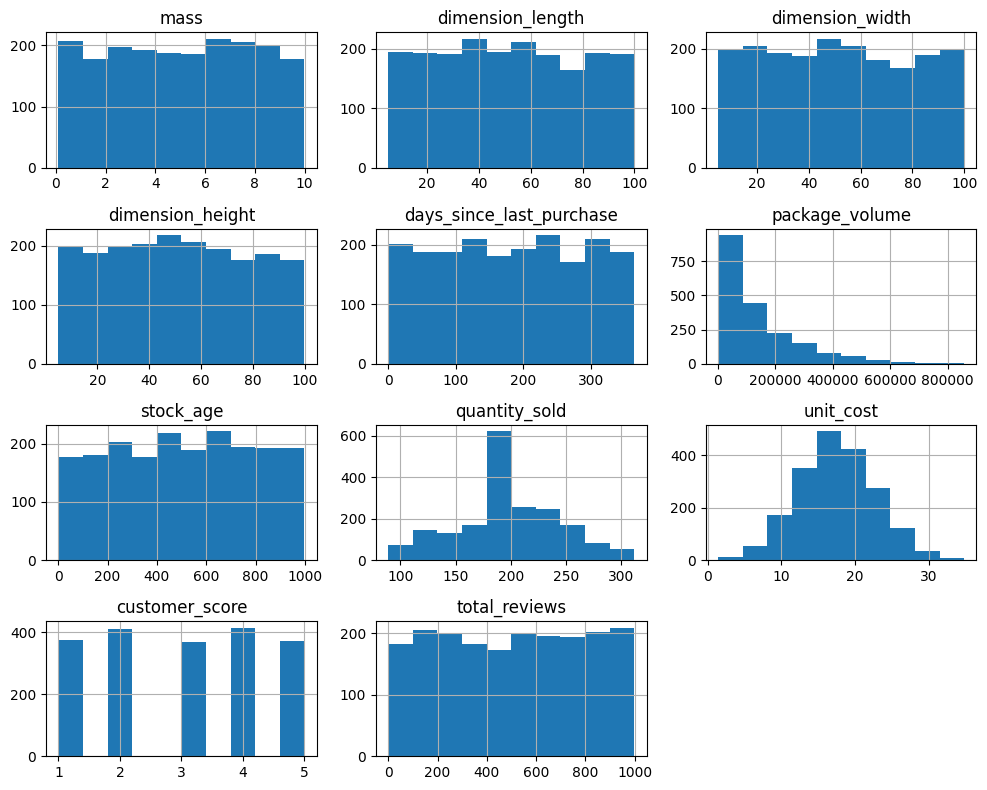

In [44]:
# Histogramme pour tous les features numériques
data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()


Box plots to check for outliers:


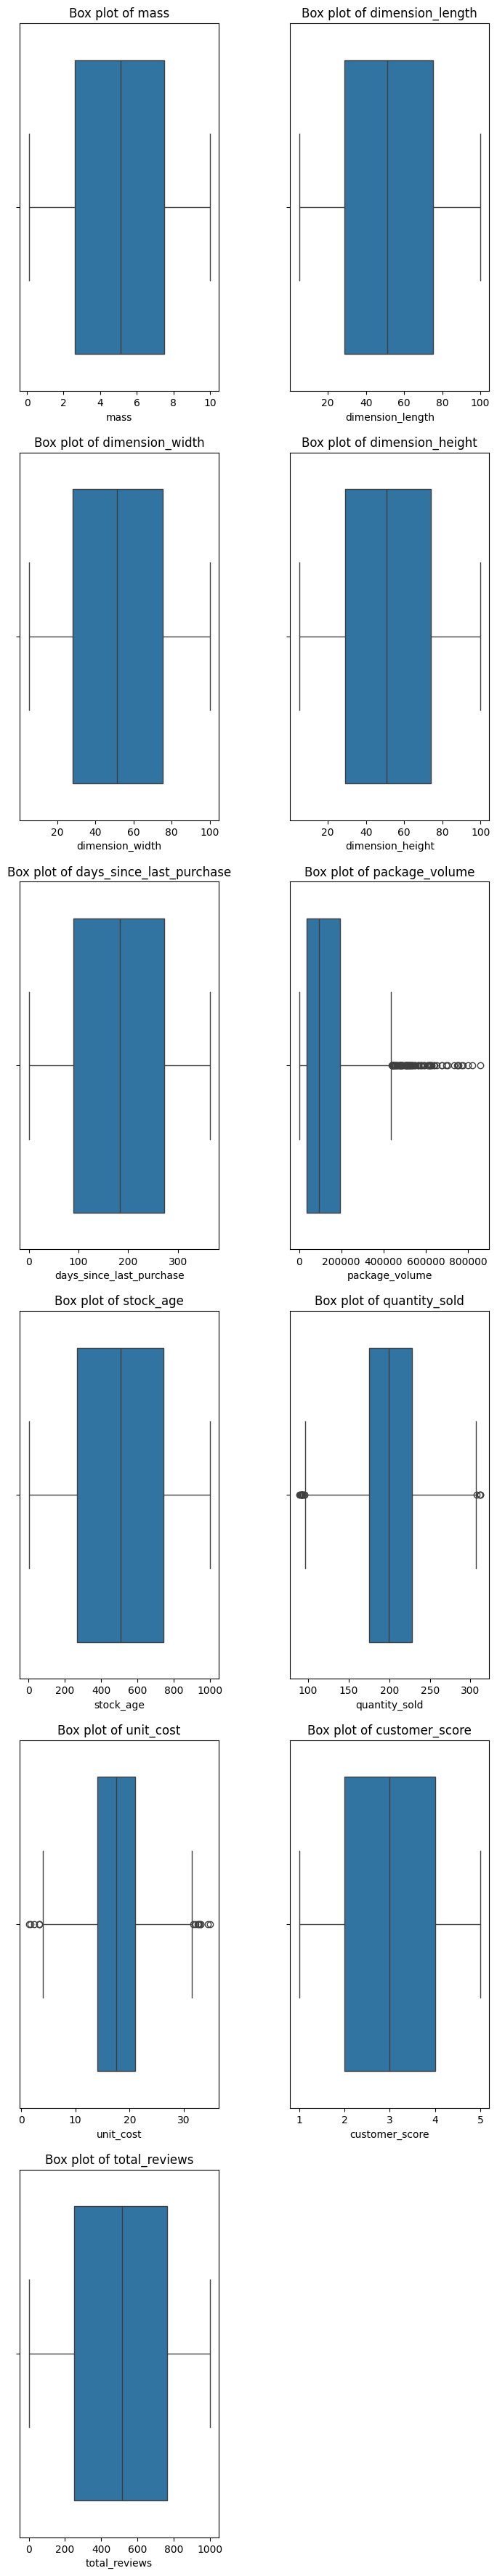

In [45]:
# Detection des outliers

# Box plots for numerical variables to check outliers
print("\nBox plots to check for outliers:")
#numeric_cols = ["unit_cost", "customer_score", "total_reviews"]

# Sélection automatique des colonnes numériques
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# Set up the plot grid
n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, n_rows*6))
fig.tight_layout(pad=4.0)

for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col_pos = i % n_cols
    sns.boxplot(x=data[col], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Box plot of {col}')

# Remove empty subplots if the number of columns is odd
if len(numeric_cols) % n_cols != 0:
    for j in range(len(numeric_cols), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

plt.show()


Correlation matrix:


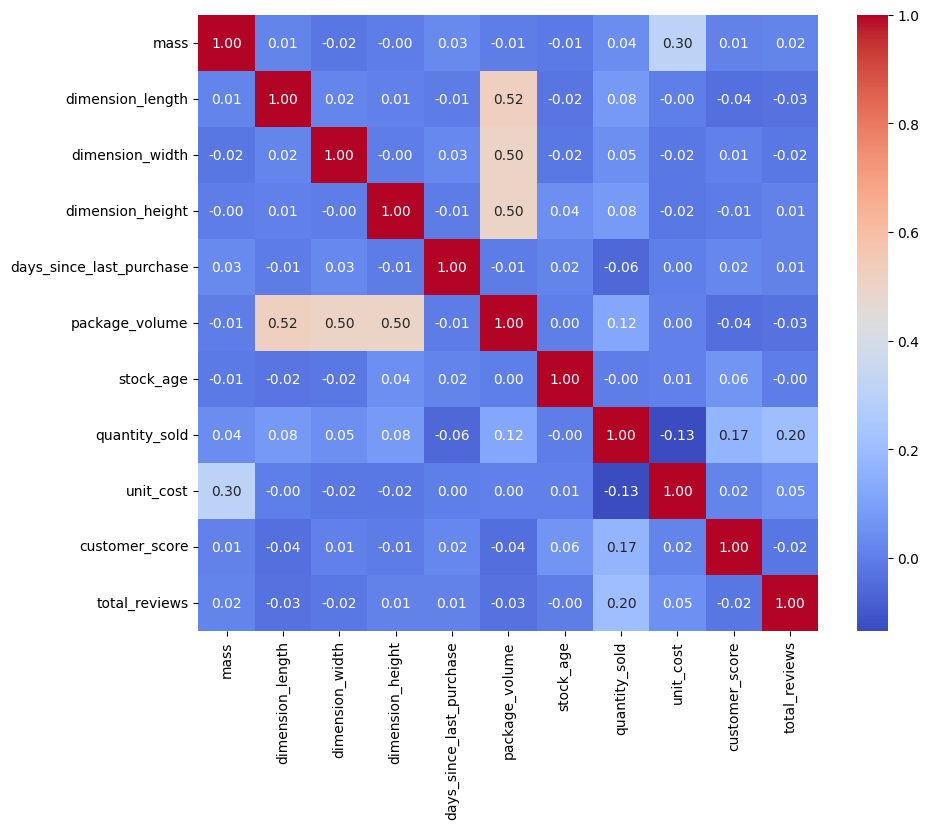

In [46]:
# Correlation matrix
print("\nCorrelation matrix:")
#corr_matrix = data.corr()
corr_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### Simple baseline

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def get_simple_baseline(data, fillna_value=-1, drop_cols=None, k_fold=5, scaler='standard', model='linear', metric='mae', target_col=None, X_data_test=None):
    
    data = data.copy()
    # Handle missing values
    data.fillna(fillna_value, inplace=True)
    if X_data_test is not None:
        X_data_test = X_data_test.copy()
        X_data_test.fillna(fillna_value, inplace=True)
    
    # Drop unwanted columns
    if drop_cols:
        data.drop(drop_cols, axis=1, inplace=True)
        if X_data_test is not None:
            X_data_test.drop(drop_cols, axis=1, inplace=True)

    # Split data into features (X) and target (y)
    y = data[target_col]
    X = data.drop(target_col, axis=1)

    # Feature scaling
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = None
    
    if scaler:
        X = scaler.fit_transform(X)
        if X_data_test is not None:
            X_data_test = scaler.transform(X_data_test)

    # Initialize the model
    if model == 'linear':
        model = LinearRegression()
    elif model == 'logistic':
        model = LogisticRegression()
    elif model == 'random_forest':
        model = RandomForestClassifier()
    else:
        raise ValueError("Unsupported model type")

    # Initialize cross-validation
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    scores = []

    # Train and evaluate using k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate using the specified metric
        if metric == 'mae':
            score = mean_absolute_error(y_test, y_pred)
        elif metric == 'accuracy':
            score = accuracy_score(y_test, np.round(y_pred))
        else:
            raise ValueError("Unsupported metric")

        scores.append(score)

    if X_data_test is not None:
        model.fit(X, y)
        return np.mean(scores), model.predict(X_data_test)
    
    # Return the average score
    return np.mean(scores)

In [48]:
# Entrainement du model
supp =['mass', 'dimension_length', 'dimension_width', 'dimension_height','days_since_last_purchase', 'stock_age']
data.columns

Index(['mass', 'dimension_length', 'dimension_width', 'dimension_height',
       'days_since_last_purchase', 'package_volume', 'stock_age',
       'quantity_sold', 'unit_cost', 'customer_score', 'total_reviews'],
      dtype='object')

In [49]:
get_simple_baseline(data, drop_cols=supp, k_fold=5, scaler='standard', model='linear', metric='mae', target_col='quantity_sold')

np.float64(33.79108490886291)

# Get test data and Predict baseline

In [50]:
# read
df_StoreE =  pd.read_csv("Neighborhood_Market_data.csv", sep=",", index_col='item_code')
df_StoreE

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,last_modified
item_code,,,,,,,,,
P0002,Neighborhood_Market,5.51,51.79,46.72,72.02,344,174261.666176,287,2023-01-02
P0004,Neighborhood_Market,3.97,84.63,39.42,42.46,189,141651.425916,387,2023-01-04
P0005,Neighborhood_Market,5.99,39.33,83.51,5.12,183,16816.375296,382,2023-01-05
P0010,Neighborhood_Market,4.10,77.43,49.56,74.41,208,285543.225828,656,2023-01-10
P0013,Neighborhood_Market,6.96,95.39,34.61,23.24,114,76725.649196,755,2023-01-13
...,...,...,...,...,...,...,...,...,...
P1972,Neighborhood_Market,5.68,17.89,71.87,95.67,296,123008.113881,411,2028-05-25
P1977,Neighborhood_Market,1.53,84.32,64.91,66.30,171,362873.902560,702,2028-05-30
P1991,Neighborhood_Market,7.79,84.46,82.96,52.14,50,365334.635424,190,2028-06-13


In [51]:
# On ajoute les colonnes de df_volumes et df_course
df_StoreE = pd.merge(df_StoreE, df_prices, left_index=True, right_index=True, how='left')
df_StoreE = pd.merge(df_StoreE, df_course_exo, left_index=True, right_index=True, how='left')
df_StoreE

,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,last_modified,unit_cost,customer_score,total_reviews
item_code,,,,,,,,,,,,
P0002,Neighborhood_Market,5.51,51.79,46.72,72.02,344,174261.666176,287,2023-01-02,26.91,3,260
P0004,Neighborhood_Market,3.97,84.63,39.42,42.46,189,141651.425916,387,2023-01-04,7.04,5,512
P0005,Neighborhood_Market,5.99,39.33,83.51,5.12,183,16816.375296,382,2023-01-05,20.84,3,85
P0010,Neighborhood_Market,4.10,77.43,49.56,74.41,208,285543.225828,656,2023-01-10,10.00,2,709
P0013,Neighborhood_Market,6.96,95.39,34.61,23.24,114,76725.649196,755,2023-01-13,12.98,3,984
...,...,...,...,...,...,...,...,...,...,...,...,...
P1972,Neighborhood_Market,5.68,17.89,71.87,95.67,296,123008.113881,411,2028-05-25,15.88,2,854
P1977,Neighborhood_Market,1.53,84.32,64.91,66.30,171,362873.902560,702,2028-05-30,16.21,1,991
P1991,Neighborhood_Market,7.79,84.46,82.96,52.14,50,365334.635424,190,2028-06-13,15.32,1,572


In [52]:
df_StoreE = dataClean(df_StoreE)

In [53]:
_, y_pred = get_simple_baseline(data,
                    fillna_value=-1,
                    drop_cols=supp,
                    k_fold=5,
                    scaler='standard',
                    model='linear',
                    metric='mae',
                    target_col='quantity_sold',
                    X_data_test=df_StoreE)

In [54]:
y_pred

array([180.61814399, 225.60053581, 175.47346097, 216.93733581,
       219.23247461, 200.1695226 , 187.64216322, 187.44128817,
       199.02239744, 198.98681226, 215.6960765 , 203.27200727,
       209.83111497, 211.19807719, 217.99838772, 206.23475075,
       202.4427657 , 184.96766579, 211.50060868, 198.0973403 ,
       210.17864419, 185.96166954, 216.98455751, 187.80544458,
       202.53096533, 177.89054213, 250.14397751, 213.63795094,
       173.12529081, 192.55419972, 204.87543776, 220.46752078,
       179.47905496, 204.6606843 , 228.21766865, 206.53115672,
       200.10708555, 195.6531423 , 227.13137134, 190.81690198,
       200.20103583, 182.18039463, 178.18932347, 173.03160337,
       189.27860681, 196.17325103, 238.42030165, 193.55105653,
       192.79951068, 196.83844213, 215.01727425, 209.60962652,
       215.27778338, 182.81890647, 206.95295014, 201.82691735,
       179.11538073, 206.8621877 , 200.76495795, 173.3342601 ,
       184.17046069, 212.48287916, 177.08564374, 204.20

In [55]:
submission = pd.DataFrame({
    'item_code': df_StoreE.index,
    'quantity_sold': y_pred # your_prediction
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,item_code,quantity_sold
0,P0002,180.618144
1,P0004,225.600536
2,P0005,175.473461
3,P0010,216.937336
4,P0013,219.232475
